# Exploratory data analysis

We use data from the paper *Searching for Collective Behavior in a Large Network of Sensory Neurons*, which was made available at [research explorer](https://research-explorer.app.ist.ac.at/record/5562
). A description of the data is as follows:
> a .txt file containing the same data represented as an array with dimensions “number of neurons” x “number of samples”, where the number of samples is equal to the product of the number of repeats and timebins within a repeat. The time dimension is divided into 20 ms time windows, and the array is binary indicating whether a given cell elicited at least one spike in a given time window during a particular repeat.

There were 953 time bins per stimulus and 297 repeats, hence a total of 283041 samples.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from numba import njit, prange

In [3]:
arr = np.load("../data/shuffled_data/data2014.npy") #load the data

In [4]:
arr.dtype

dtype('int64')

In [5]:
N,M = arr.shape # get the array's shape

In [6]:
N_T = 953 # number of bins per trial

In [7]:
print(N,M,953*297)

160 283041 283041


## Visualise data
We first want to get a sense of what the data looks like. We look at timeseries plots of the number of neurons that fire and also when some individual neurons fired. 

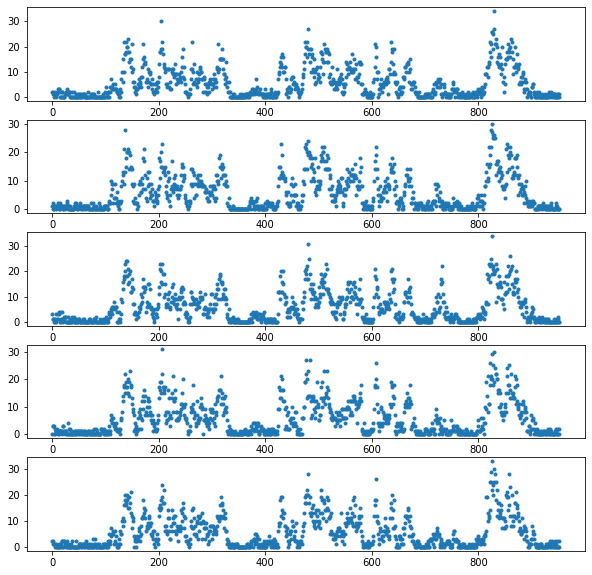

In [8]:
#plt how many neurons fire in each time bin over first few trials
trials_to_plot = 5
f,axes = plt.subplots(trials_to_plot,1,figsize=(10,10))
for i in range(200,200+trials_to_plot):
    axes[i-200].plot(np.sum(arr,axis=0)[i*N_T:(i+1)*N_T],".")
plt.show()

Find the most active neuron and observe its activity across different trials.

In [11]:
T_counts = np.sum(arr,axis=1)
T_counts # how often different neurons fired

array([ 7953,  2265,  4013,  4741,  6061,  6013,  6921, 22694, 11730,
        1678, 15648,  7610,  9064,  2659,  1024,  4377, 12861,  3406,
        5719, 33222, 14041, 31754,  4632,  1288, 26947, 12928,  2101,
        7780, 19546, 17554,  5534, 10597, 13030, 38083,  6254,  5254,
       13622, 11899,  7808, 14274, 19264,  1614, 12686,  8480, 14506,
       12747,  7425, 12704, 13344, 14056, 12312, 45994,  9414, 16147,
         609, 13851, 10370, 11340,  1841,  2907,  9454, 10568, 12743,
       12968, 37348,  5161, 16186,  8735,  2797, 24367, 14697, 37218,
        2577,  4035,  1236,  9295,  7775, 11044,  4695,  2146, 13280,
        3534, 14411, 12111,  5339,  4745,  6323,  6512,  4167,  8734,
         716, 24953,  4924, 13284, 13435,  7040, 10561,  3313, 11038,
       14547,  6383,  1442,  4648,   952,   930, 28763,  5045,  6807,
       17979,  5076, 11717,  1686,  4604, 11519, 19409, 17555,  1563,
       12336, 16464, 12935,  6937, 19622, 13570,  3723,  4350, 18779,
       16445, 14515,

In [12]:
most_act_ind = np.argmax(T_counts) # find the most active neuron
least_act_ind = np.argmin(T_counts) # least active neuron

most_act_ind, least_act_ind

(51, 136)

In [13]:
m_neuron_activity = arr[most_act_ind].reshape(-1,N_T)
l_neuron_activity = arr[least_act_ind].reshape(-1,N_T)

In [14]:
def plot_neuron_activity(neuron_activity):
    plt.figure(figsize=(12,3))
    plt.imshow(neuron_activity)
    plt.xlabel("Time")
    plt.ylabel("Different presentations of stimulus")
    plt.title("When the neuron fires across different presentations of stimulus")
    plt.show()

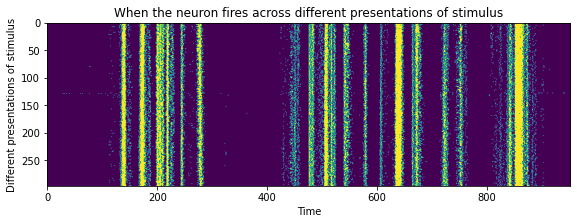

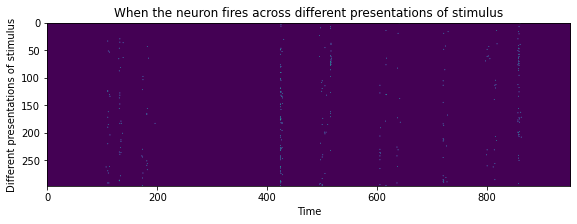

In [15]:
plot_neuron_activity(m_neuron_activity)
plot_neuron_activity(l_neuron_activity)

Plot the activity of other neurons

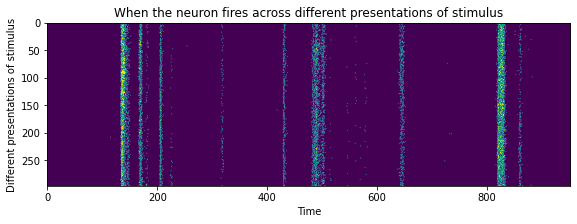

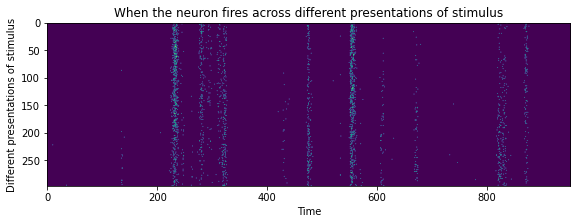

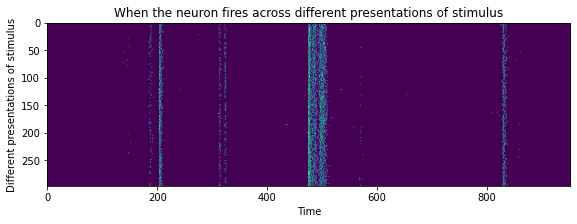

In [16]:
n_neurons = 3
for n in range(n_neurons):
    neuron_activity = arr[n].reshape(-1,N_T)
    plot_neuron_activity(neuron_activity)

## Statistics
We look at various statistics from the data, such as how often indivudal neurons fired.

### Averages

In [10]:
avgs = np.mean(arr,axis=1) # get the mean firing of neurons
# avgs

In [11]:
def summary(arr,dp=3):
    print( "Mean", np.round(np.mean(arr),dp), "S.D.", np.round(np.std(arr),dp), "Min", np.round(np.min(arr),dp), "Max", np.round(np.max(arr),dp), sep=", " )

In [12]:
summary(avgs)

Mean, 0.036, S.D., 0.029, Min, 0.001, Max, 0.162


In [13]:
def hist(arr,title,bins=100):
    plt.hist(arr,bins)
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

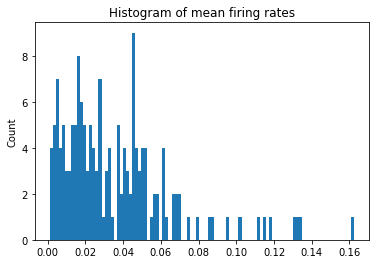

In [14]:
hist(avgs,"Histogram of mean firing rates")

### Correlations

In [23]:
@njit
def correlations(arr):
    N, M = arr.shape
    corrs = np.zeros((N,N))
    for i in range(N-1):
        for j in range(i+1,N):
            corrs[i,j]=np.sum(arr[i]*arr[j])    
    return corrs / M

def flatten(mat):
    return mat[np.triu_indices_from(mat,k=1)]

In [24]:
corr_mat = correlations(arr) #correlation matrix
corrs = flatten(corr_mat)

In [25]:
summary(corrs)

Mean, 0.003, S.D., 0.004, Min, 0.0, Max, 0.075


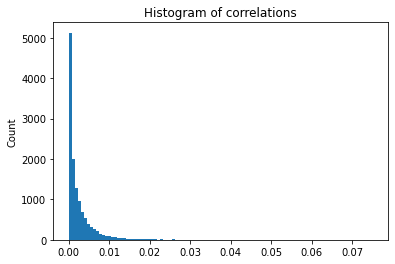

In [26]:
hist(corrs,"Histogram of correlations")

Are most of the correlations very close to those predicted by a model that assumes each neuron fires independently? If so, then $ \langle \sigma_i \sigma_j \rangle \approx \langle \sigma_i \rangle \langle \sigma_j \rangle $.

In [30]:
indep_corr_mat = np.triu(np.outer(avgs,avgs),1)
indep_corrs = flatten(indep_corr_mat)
indep_diff_mat = np.abs(indep_corr_mat - corr_mat)
indep_diff = flatten(indep_diff_mat) #flatten and select non-zero elements

In [31]:
summary(indep_diff)

Mean, 0.001, S.D., 0.003, Min, 0.0, Max, 0.059


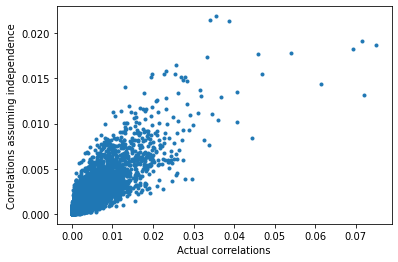

In [36]:
plt.plot(corrs, indep_corrs, ".")
plt.xlabel("Actual correlations")
plt.ylabel("Correlations assuming independence")
plt.show()

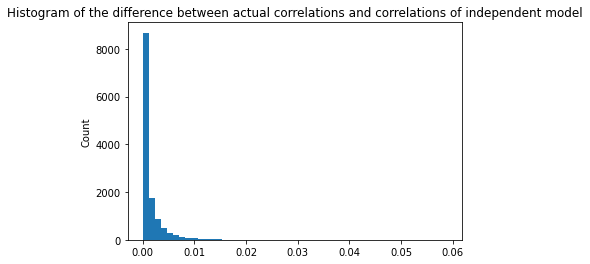

In [32]:
hist(indep_diff,"Histogram of the difference between actual correlations and correlations of independent model")

### Prob. of K neurons firing

In [33]:
counts = np.sum(arr,axis=0)
p_k = np.bincount(np.sum(arr,axis=0))/M

In [34]:
summary(counts)

Mean, 5.732, S.D., 6.169, Min, 0, Max, 45


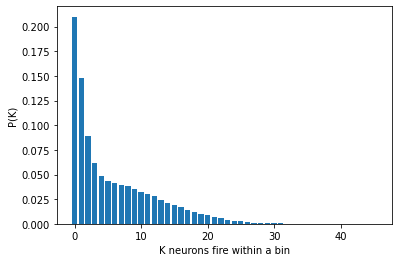

In [35]:
plt.bar(np.arange(len(p_k)),p_k)
plt.xlabel("K neurons fire within a bin")
plt.ylabel("P(K)")
plt.show()

## Variance of statistics across subsets
How does the distribution of various statistics look when we choose different subsets of neurons?

In [2]:
train_data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=int)

In [3]:
NNs = np.array([10,40,100])
reps = np.arange(1,31)

In [4]:
def get_subset(data, NN, rep):
    ids = np.loadtxt(f"../data/subsets/{NN}_{rep}.csv", delimiter=",", dtype=int)
    return data[ids-1] # since matlab zero index

In [5]:
sub1 = get_subset(train_data, NNs[0], reps[0])

We want to compare the distribution of statistics, such as the meaning firing, across different subsets of neurons. Since we are note sure how these statistics are distributed, we plot the five number summary.

In [6]:
def five_sum(data):
    quartiles = np.percentile(data, [25,50,75])
    mins = np.min(data)
    low_qs = quartiles[0]
    meds = quartiles[1]
    upp_qs = quartiles[2]
    maxs = np.max(data)
    return [mins, low_qs, meds, upp_qs, maxs]

In [7]:
def plot_quartiles(ex, color="black",offset=0):
    low_diffs = ex[:,1] - ex[:,0] # from min to lower quartile
    upp_diffs = ex[:,4] - ex[:,3] # from upper quartile to max
    subs = np.arange(ex.shape[0])
    # plot upper quartile
    plt.errorbar(subs+offset, ex[:,3],yerr=np.stack(( np.zeros(ex.shape[0]), upp_diffs )), #yerr is (below error, above error)
                 fmt="none",ecolor=color,elinewidth=0.8)
    # plot median
    plt.plot(subs+offset, ex[:,2],"_", color=color)
    # plot upper quartile
    plt.errorbar(subs+offset, ex[:,1],yerr=np.stack(( low_diffs, np.zeros(ex.shape[0]) )), #yerr is (below error, above error)
                 fmt="none",ecolor=color,elinewidth=0.8)

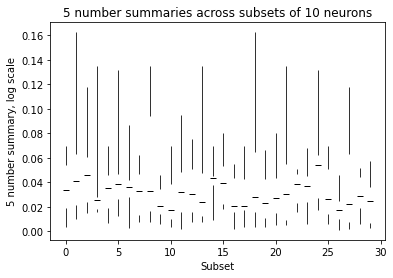

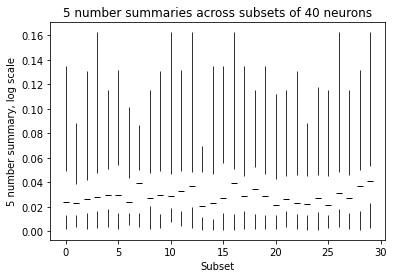

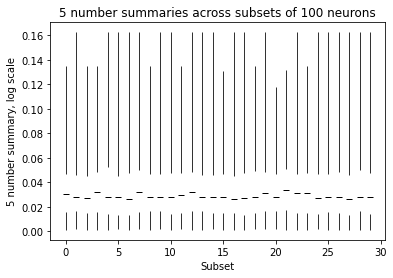

In [9]:
for i in range(len(NNs)):
    NN = NNs[i]
    summaries = [] # (no. subsets x 5) matrix
    for j in range(len(reps)):
        rep = reps[j]
        subset = get_subset(train_data, NN, rep)
        means = np.mean(subset, axis=1)    
        # get the five number summary of the mean firing rates from this subset
        summaries.append(five_sum(means))
        
    plot_quartiles(np.array(summaries))
#     plt.yscale("log")
    plt.xlabel("Subset")
    plt.ylabel("5 number summary, log scale")
    plt.title(f"5 number summaries across subsets of {NN} neurons")
    plt.show()

## Shuffling
Are the shuffle across time and shuffle across trials sets practically the same? 
To test this, we compare the averages calculated over $R=50$ randomly chosen trials-presentations of the stimulus (comprising $953$ observations) to the averages worked out over $R * 953$ randomly chosen observations. We choose $R=50$  trials somewhat arbitrarily. This is just less than $20\%$ of the total number of trials (297), and 

In [11]:
train_rep = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=int)
trials = train_rep.reshape((160,-1,953)) # reshape so can quickly extract different trials
train_time = np.loadtxt("../data/shuffled_data/time_shuffle_train.csv", delimiter=",", dtype=int)

def get_R_repeats(R):
    return trials[:, np.random.choice(trials.shape[1],R,replace=False)].reshape((trials.shape[0],-1))

def get_R953_obs(R):
    return train_time[:, np.random.choice(train_time.shape[1],R*trials.shape[2],replace=False)]

In [26]:
trials.shape[2]

953

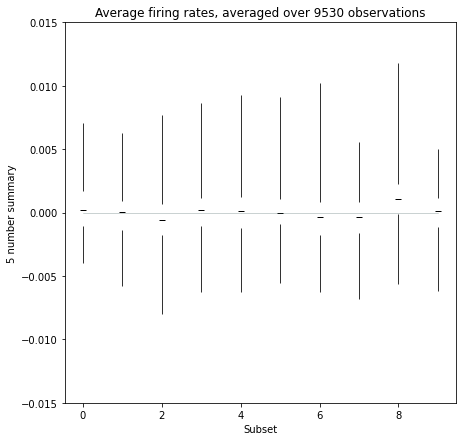

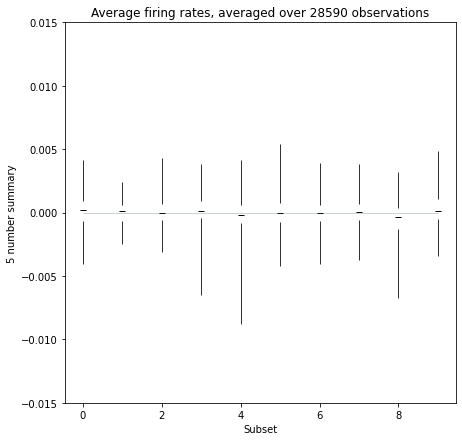

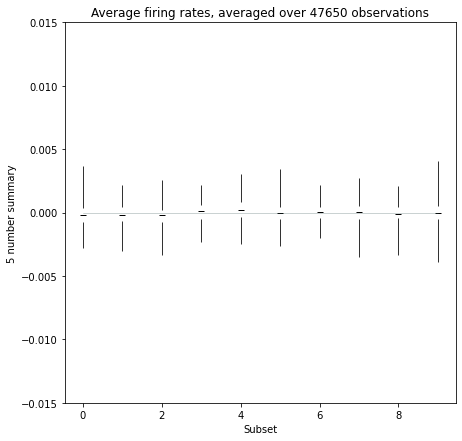

In [38]:
np.random.seed(42)
Rs = [10,30,50]
subsets = 5

for i in range(len(Rs)):
    plt.figure(figsize=(7,7))
    R = Rs[i]
    summaries = [] 
    for _ in range(10):
        reps = get_R_repeats(R)
        obs = get_R953_obs(R)
        # get the five number summary of the mean firing rates from this subset
        summaries.append(five_sum( np.mean(obs,axis=1) - np.mean(reps,axis=1) ))
        
    plot_quartiles(np.array(summaries))
    plt.ylim((-0.015,0.015))
    plt.plot(np.arange(10), np.zeros(10),"-",color="darkslategrey",alpha=0.5,linewidth=0.5)
    plt.xlabel("Subset")
    plt.ylabel("5 number summary")
    plt.title(f"Average firing rates, averaged over {R*953} observations")
    plt.show()